# Notebook 3 - Climatic Constraints

<hr>
In this module, various yield reduction factors will be applied to the maximum attainable yield estimated from Module 2.

Prepared by Geoinformatics Center, AIT
<hr>

### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal
# # !pip install pyaez==2.0.0


Now, we will import the specific Python packages we need for PyAEZ.

In [2]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys


Setting the working directory -- where our PyAEZ project is located.

In [3]:
'Set the working directory'
# Replace with path to your PyAEZv2 folder
work_dir = '/Volumes/GoogleDrive/My Drive/PyAEZv2_FINAL_DRAFT'
os.chdir(work_dir)
sys.path.append('./pyaez/')
!pwd

# Check whether the specified path exists or not
out_path = './data_output/NB1/'
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")


/Volumes/GoogleDrive/My Drive/PyAEZv2_FINAL_DRAFT


<hr>

## MODULE 3: CLIMATE CONSTRAINTS
Now, we will start executing the routines in Module 3


First, we initiate Module 3 Class instance by invoking the following commands:

In [4]:
'''importing library'''
import ClimaticConstraints
clim_constraints = ClimaticConstraints.ClimaticConstraints()

import UtilitiesCalc
obj_utilities = UtilitiesCalc.UtilitiesCalc()

In [7]:
# Load the geographical data/rasters
mask_path = './data_input/LAO_Admin.tif'
mask = gdal.Open(mask_path).ReadAsArray()


In [8]:
'''Reading data'''
lgp_equv = gdal.Open(r'./data_output/NB1/LAO_LGPEquivalent.tif').ReadAsArray();

lgp = gdal.Open(r'./data_output/NB1/LAO_LGP.tif').ReadAsArray();

yield_rain = gdal.Open(
    r'./data_output/NB2/LAO_CropSuitability_rain.tif').ReadAsArray()
yield_irr = gdal.Open(
    r'./data_output/NB2/LAO_CropSuitability_irr.tif').ReadAsArray()


### Apply the climate constraints

In [9]:
'''applying climate constraints'''
clim_adj_yield_irr = clim_constraints.applyClimaticConstraints(
    lgp_equv, yield_irr, 'I')  # I for irrigated
clim_adj_yield_rain = clim_constraints.applyClimaticConstraints(
    lgp_equv, yield_rain, 'R')  # R for rainfed


### Final Yield Classification (after Climate reduction)
Yield classification
1.   not suitable (yields between 0% and 20%)
2.   marginally suitable (yields between 20% and 40%)
3.   moderately suitable (yields between 40% and 60%)
4. suitable (yields between 60% and 80%)
5. very suitable (yields are equivalent to 80% or more of the overall maximum yield)

In [10]:
# get classified output of yield
clim_adj_yield_rain_class = obj_utilities.classifyFinalYield(
    clim_adj_yield_irr)
clim_adj_yield_irr_class = obj_utilities.classifyFinalYield(clim_adj_yield_irr)


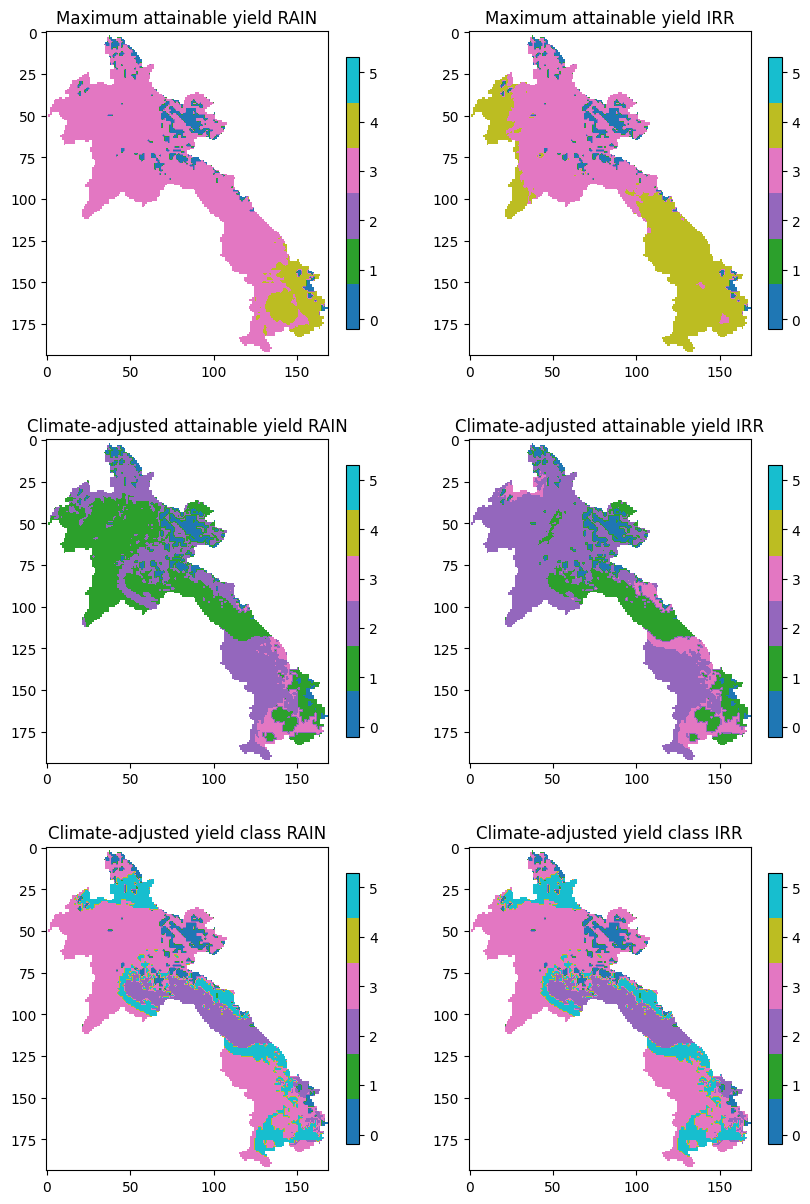

In [11]:
'''visualize result'''

plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
plt.imshow(np.ma.masked_where(mask==0,yield_rain),cmap=plt.get_cmap('tab10',6),vmin=-0.2,vmax=5.3)
plt.title('Maximum attainable yield RAIN')
plt.colorbar(shrink=0.8)

plt.subplot(3,2, 2)
plt.imshow(np.ma.masked_where(mask == 0, yield_irr),
           cmap=plt.get_cmap('tab10', 6), vmin=-0.2, vmax=5.3)
plt.title('Maximum attainable yield IRR')
plt.colorbar(shrink=0.8)


plt.subplot(3,2,3)
plt.imshow(np.ma.masked_where(mask == 0, clim_adj_yield_rain),
           cmap=plt.get_cmap('tab10', 6), vmin=-0.2, vmax=5.3)
plt.title('Climate-adjusted attainable yield RAIN')
plt.colorbar(shrink=0.8)

plt.subplot(3,2, 4)
plt.imshow(np.ma.masked_where(mask == 0, clim_adj_yield_irr),
           cmap=plt.get_cmap('tab10', 6), vmin=-0.2, vmax=5.3)
plt.title('Climate-adjusted attainable yield IRR')
plt.colorbar(shrink=0.8)

plt.subplot(3,2, 5)
plt.imshow(np.ma.masked_where(mask == 0, clim_adj_yield_rain_class),
           cmap=plt.get_cmap('tab10', 6), vmin=-0.2, vmax=5.3)
plt.title('Climate-adjusted yield class RAIN')
plt.colorbar(shrink=0.8)

plt.subplot(3,2, 6)
plt.imshow(np.ma.masked_where(mask == 0, clim_adj_yield_irr_class),
           cmap=plt.get_cmap('tab10', 6), vmin=-0.2, vmax=5.3)
plt.title('Climate-adjusted yield class IRR')
plt.colorbar(shrink=0.8)


plt.savefig("./data_output/NB3/LAO_ClimConstraints.png",bbox_inches='tight',dpi=300)


In [12]:
# saving the output as TIFF file
obj_utilities.saveRaster(mask_path,r'./data_output/NB3/LAO_clim_adj_yield_map_rain.tif', clim_adj_yield_rain)
obj_utilities.saveRaster(mask_path,r'./data_output/NB3/LAO_clim_adj_yield_map_rain_class.tif', clim_adj_yield_rain_class)
obj_utilities.saveRaster(mask_path,r'./data_output/NB3/LAO_clim_adj_yield_map_irr.tif', clim_adj_yield_irr)
obj_utilities.saveRaster(mask_path,r'./data_output/NB3/LAO_clim_adj_yield_map_irr_class.tif', clim_adj_yield_irr_class)


<hr>

### END OF MODULE 3: Climatic Constraints

<hr>